# Comparing regvelo and velovi inferred latent time

Notebook compare latent time inference

## Library imports

In [1]:
import random

import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import anndata as ad
import scvelo as scv
import scvi
from regvelo import REGVELOVI
from velovi import VELOVI

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.benchmarking import set_output
from rgv_tools.core import METHOD_PALETTE
from rgv_tools.plotting import get_significance

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda

## General settings

In [2]:
scvi.settings.dl_pin_memory_gpu_training = False

## Function defination

In [3]:
def compute_confidence(adata, vkey="velocity"):
    """Compute confidence."""
    adata.layers[vkey]
    scv.tl.velocity_graph(adata, vkey=vkey, n_jobs=1)
    scv.tl.velocity_confidence(adata, vkey=vkey)

    g_df = pd.DataFrame()
    g_df["Latent time consistency"] = adata.obs[f"{vkey}_confidence"].to_numpy().ravel()

    return g_df

## Constants

In [4]:
DATASET = "cell_cycle"

In [5]:
significance_palette = {"n.s.": "#dedede", "*": "#90BAAD", "**": "#A1E5AB", "***": "#ADF6B1"}

In [6]:
STATE_TRANSITIONS = [("G1", "S"), ("S", "G2M")]

In [7]:
SAVE_DATA = True
SAVE_FIGURES = True

if SAVE_DATA:
    (DATA_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)
if SAVE_FIGURES:
    (FIG_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)

## Data loading

In [8]:
adata = ad.io.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_processed.h5ad")
adata

AnnData object with n_obs × n_vars = 1146 × 395
    obs: 'phase', 'fucci_time', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'ensum_id', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'log1p', 'neighbors', 'pca', 'umap', 'velocity_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs', 'true_skeleton'
    layers: 'Ms', 'Mu', 'spliced', 'total', 'unspliced', 'velocity'
    obsp: 'connectivities', 'distances'

## Model loading

In [9]:
vae = REGVELOVI.load(DATA_DIR / DATASET / "regvelo_model", adata)

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...


INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/cell_cycle/regvelo_model/model.pt already         
         downloaded                                                                                                


In [10]:
set_output(adata, vae, n_samples=30, batch_size=adata.n_obs)
adata_regvelo = adata.copy()

## Running veloVI as baseline

In [11]:
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train(max_epochs=1500)

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -539.276. Signaling Trainer to stop.


In [12]:
set_output(adata, vae, n_samples=30)
adata_velovi = adata.copy()

## replacing velocity as the latent time

In [13]:
dfs = []

g_df = compute_confidence(adata_regvelo, vkey="fit_t")
g_df["Dataset"] = "Cell cycle"
g_df["Method"] = "regvelo"
dfs.append(g_df)

g_df = compute_confidence(adata_velovi, vkey="fit_t")
g_df["Dataset"] = "Cell cycle"
g_df["Method"] = "velovi"
dfs.append(g_df)

conf_df = pd.concat(dfs, axis=0)

computing velocity graph (using 1/112 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'fit_t_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'fit_t_length' (adata.obs)
--> added 'fit_t_confidence' (adata.obs)
--> added 'fit_t_confidence_transition' (adata.obs)
computing velocity graph (using 1/112 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'fit_t_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'fit_t_length' (adata.obs)
--> added 'fit_t_confidence' (adata.obs)
--> added 'fit_t_confidence_transition' (adata.obs)


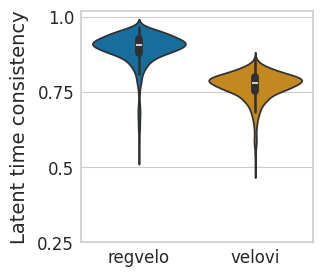

In [14]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 3))

    sns.violinplot(
        data=conf_df,
        ax=ax,
        # orient="h",
        x="Method",
        y="Latent time consistency",
        order=["regvelo", "velovi"],
        palette=METHOD_PALETTE,
    )
    # plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)
    ax.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels([0.25, 0.5, 0.75, 1.0])
    plt.xlabel("")

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / "Latent_time_consistency.svg", format="svg", transparent=True, bbox_inches="tight"
        )
    plt.show()

## Calculate fold change

In [15]:
graph = adata.obsp["connectivities"].A

In [16]:
Time_FC = []
for i in range(graph.shape[0]):
    v = adata_regvelo[i].layers["fit_t"]
    m = adata_regvelo[graph[i, :] != 0].layers["fit_t"]
    cos_similarities = cosine_similarity(v, m)

    ## randomly sample each number of cells
    indices = random.sample(range(0, adata.shape[0]), m.shape[0])
    m = adata_regvelo[indices].layers["fit_t"]
    cos_similarities_random = cosine_similarity(v, m)

    FC = np.mean(cos_similarities) / np.mean(cos_similarities_random)
    Time_FC.append(FC)

In [17]:
b = np.zeros(len(Time_FC))
_, p_value = wilcoxon(Time_FC, b, alternative="greater")
p_value

2.592628865738403e-189

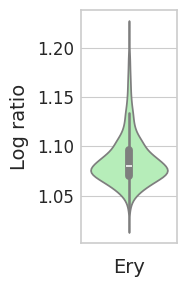

In [18]:
b = np.zeros(len(Time_FC))
_, p_value = wilcoxon(Time_FC, b, alternative="greater")
significance = get_significance(p_value)
palette = significance_palette[significance]

# Step 3: Create the boxplot
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, axes = plt.subplots(figsize=(2, 3))

    # Step 4: Color based on significance

    sns.violinplot(data=Time_FC, color=palette)

    # Add titles and labels
    plt.xlabel("Ery")
    plt.ylabel("Log ratio")

    fig.tight_layout()
    plt.show()

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / "Latent_time_consistency_test.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )